### 1D Burger Equation NFTM Simulator using a CNN as the controller and recurrent (rollout) training loop

The Burger equation in 1-dimension is given by:

$$
\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}
$$


* We want to build a NFTM with a CNN-based update rule for simulating the 1D Burgers equation.

* NFTM architecture:
    * Neural Controller $C$ $\to$ CNN in this case.

    * Continuous memory field (spatial domain) $f_t$: **updates are restricted to neighbour points**.

    * Movable read/write heads that perform **local updates** $h_t$: operate over local regions/patches of this field.

* NFTM architecture for PDEs:
    * The continuous **field** models the spatial domain, a grid representing the solutions $u(x,t)$.

    * The **controller** reads a local patch (neighbourhood) at each time step, computes an update (using CNN), and writes the new value back (updates values in the field). Responsible of updating values + controlling position of read/write heads.

    * At each time step $t$ the CNN controller reads a region, for example: $[u_{i-1}, u_i, u_{i+1}]$ (in 1D) as its input.

    * The CNN uses this input to compute updates by applying a CNN kernel and then writes the updated values back to the same region.

#### Import necessary packages 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from pathlib import Path
import os
import math
from torch.utils.data import Dataset, DataLoader, random_split

#### Load Training Data

* The following class builds training samples for training the NFTM.

* It extracts a spatial patch (neighbouring positions) at a fixed time $t$.

* The target value is the value at the center of the patch at the next time step $(t+1)$.

* INPUT: patch along the space at time $t$: $(u_{i-k, t},...,u_{i, t},...,u_{i+k, t})$ for a specific patch size $2k +1$.

* VISCOSITY $\nu$: a scalar.

* TARGET: $u_{i, t+1}$ (center's value in the next time step).

* At time $t = 0$, we have the initial continuous field $u(x,0)$.

* The CNN controller operates locally on this spatial field $u(x,t)$ (for fixed $t$) and produces updated values.

* These updates represent the solution $u(x,t+1)$ at the next time step $(t+1)$.

* We update the field to represent $u(x,t+1)$ and repeat this iteratively ($t \to t+1$) to simulate the PDE dynamics.

### Training Data

* Input: `batch of input data patches` (shape = (batch_size, patch_size)) and a `batch of viscosities` (shape = (batch_size, 1)).

* Output: `batch of target values` at the input data patch center (shape = (batch_size, 1)).

In [2]:
class BurgersDataset(Dataset):
    def __init__(self, files_burger):
        # files_burger: dict {nu: path}
        self.trajs = [] # list of (T,N)
        self.nu_values = []   # scalar viscosities, one per traj

        for nu, path in files_burger.items():
            data = np.load(str(path.resolve()))['u'] # (100, T, N)
            data_t = torch.tensor(data, dtype = torch.float32) # (100, T, N)
    
            for traj in data_t: # traj: (T,N)
                self.trajs.append(traj)
                self.nu_values.append(nu)
        
    def __len__(self):
        return len(self.trajs)
    
    def __getitem__(self, idx):
        # Returns: tuple (initial_field (N,), full_trajectory (T, N), viscosity (1,))
        traj = self.trajs[idx]  # (T, N)
        init_field = traj[0]  # (N,)
        nu_val = torch.tensor([self.nu_values[idx]], dtype=torch.float32)
        return init_field, traj, nu_val


current_dir = Path(os.getcwd()) # get current directory

# Files with datasets for 1D burger eq for different values of viscosity:
files_burger = {
    0.001: current_dir / ".." / ".." / "Data" / "100traj_burgers1D_training_data_Nu0.001.npz",
    0.01: current_dir / ".." / ".." / "Data" / "100traj_burgers1D_training_data_Nu0.01.npz",
    0.1: current_dir / ".." / ".." / "Data" / "100traj_burgers1D_training_data_Nu0.1.npz",
    0.5: current_dir / ".." / ".." / "Data" / "100traj_burgers1D_training_data_Nu0.5.npz"
}

# The training dataset for our NFTM will consist of 4 samples (trajectories), one per viscosity value:
full_dataset = BurgersDataset(files_burger) # 400 trajectories, 100 per viscosity
# print("Patches shape:", patch_dataset.patches.shape)   # (total_samples, patch_size)
# print("Viscosities shape:", patch_dataset.nu_vals.shape)  # (total_samples, 1)
# print("Targets shape:", patch_dataset.targets.shape)  # (total_samples, 1)
print(f"Number of trajectories in dataset: {len(full_dataset)}")

_, full_traj_0, _ = full_dataset[0]

T, N = full_traj_0.shape  # full_traj_0 has shape (T = 201, N = 1024)

print(f"N={N}")
print(f"T={T}")

# Set random seed for reproducibility
torch.manual_seed(42)

# Split into train (300 trajectories) and test (100 trajectories)
train_size = 300
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])
print("Train size:", len(train_dataset))
print("Test size:", len(test_dataset))

print("Train viscosities:", [full_dataset.nu_values[i] for i in train_dataset.indices])
print("Test viscosities:", [full_dataset.nu_values[i] for i in test_dataset.indices])


init_field, full_trajectory, viscosity = full_dataset[0]
print(f"Initial field shape: {init_field.shape}")            # Expected: (N,)
print(f"Full trajectory shape: {full_trajectory.shape}")     # Expected: (T, N)
print(f"Viscosity: {viscosity.item()}")


Number of trajectories in dataset: 400
N=1024
T=201
Train size: 300
Test size: 100
Train viscosities: [0.5, 0.5, 0.5, 0.5, 0.001, 0.01, 0.1, 0.01, 0.5, 0.1, 0.1, 0.5, 0.1, 0.001, 0.01, 0.5, 0.1, 0.01, 0.5, 0.1, 0.01, 0.1, 0.1, 0.001, 0.1, 0.01, 0.1, 0.01, 0.01, 0.1, 0.001, 0.01, 0.1, 0.001, 0.1, 0.1, 0.001, 0.1, 0.5, 0.1, 0.01, 0.001, 0.5, 0.1, 0.1, 0.1, 0.001, 0.1, 0.5, 0.01, 0.01, 0.01, 0.5, 0.1, 0.001, 0.5, 0.001, 0.5, 0.001, 0.1, 0.1, 0.001, 0.5, 0.01, 0.01, 0.01, 0.01, 0.1, 0.01, 0.5, 0.5, 0.001, 0.01, 0.01, 0.001, 0.1, 0.01, 0.001, 0.1, 0.5, 0.001, 0.5, 0.5, 0.01, 0.001, 0.01, 0.1, 0.01, 0.5, 0.5, 0.001, 0.01, 0.01, 0.1, 0.5, 0.1, 0.01, 0.01, 0.01, 0.01, 0.001, 0.1, 0.5, 0.1, 0.5, 0.5, 0.001, 0.5, 0.1, 0.01, 0.001, 0.5, 0.5, 0.001, 0.5, 0.5, 0.5, 0.5, 0.001, 0.01, 0.1, 0.1, 0.01, 0.5, 0.001, 0.5, 0.5, 0.5, 0.001, 0.1, 0.01, 0.01, 0.1, 0.1, 0.1, 0.1, 0.5, 0.01, 0.1, 0.5, 0.1, 0.5, 0.001, 0.001, 0.5, 0.1, 0.1, 0.001, 0.5, 0.001, 0.001, 0.001, 0.01, 0.1, 0.1, 0.001, 0.01, 0.5, 0.001

#### Continuous field as a spatial grid

* This field acts as the memory of the NFTM, storing the solution values at each spatial point.

* Make use of tensors to represent the spatial field.

* Create a 1D tensor of size N (no. of spatial points per time snapshot): will store the values of the solution $u$ at each spatial point for a specific time snapshot.

* Each 1D tensor (vector) represents the spatial field $u(x,t)$ at a given time $t$ (fixed) and for each $[x_0,..., x_{N-1}]$, where $N=$ no. of spatial values per snapshot.

* $f_t = [u(x_0, t), ..., u(x_{N-1},t)]$.

* To compute the field at the next time step $t+\Delta t$, we use the vector from the previous time step $t$ as input.

* Each dataset corresponding to a specific viscosity contains all solution trajectories (full temporal evolutions) for that viscosity, and thus has its own set of initial fields (initial conditions $u(x,t=0)$) associated with that viscosity.

* SAME INITIAL CONDITION FOR ALL DATASETS. VALUES OF $u(x, t= 0)$ are equal, regardless of the value of $\nu$.

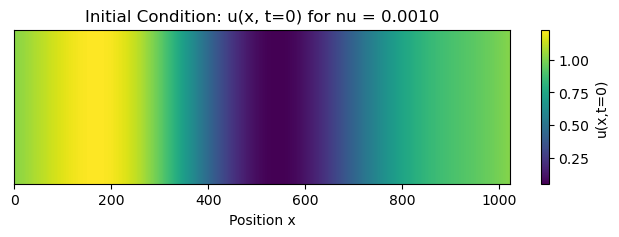

In [3]:
initial_field, full_trajectory, viscosity = full_dataset[0] # initial field for t = 0, full trajectory for nu = 0.001

# VISUALIZATION OF THE FIELD:
field_np = initial_field.numpy()

plt.figure(figsize=(8, 2))
plt.imshow(field_np[np.newaxis, :], aspect='auto', cmap='viridis', interpolation='nearest')
plt.colorbar(label='u(x,t=0)')
plt.xlabel('Position x')
plt.title(f'Initial Condition: u(x, t=0) for nu = {viscosity.item():.4f}')
plt.yticks([])
plt.show()

#### CNN controller

* Construct CNN that acts as the controller to process each patch.

* Typical architecture: input layer of size $(N, )$ + viscosity, one or two convolutional layers with kernel sizes equal or smaller than the patch size, nonlinear activations (ReLU or tanh), and output layer producing updated values for the center point in the patch.

* The CNN processes patches independently across the field.

* **Input:** full field $f_t$ (vector of size $1 \times 1024$) and viscosity $\nu$.

* **Output:** predicted field at next time step $\hat{f}_{t+1}$.
 

In [4]:
# # CNN controller definition:
# class CNNController(nn.Module):
#     def __init__(self, field_size):
#         super().__init__()
#         self.patch_size = field_size
#         # Two input channels (in_channels = 2): field patch and viscosity
#         # First convolutional layer:
#         self.conv1 = nn.Conv1d(in_channels=2, out_channels=32, kernel_size=5, padding=0) # output shape: (batch_size, 32, 1).
#         # ReLU activation function -> introduces non-linearity
#         self.activation1 = nn.ReLU()
#         # Add batch normalization for better training stability
#         self.bn1 = nn.BatchNorm1d(32)
#         # Second convolutional layer: kernel_size = 1 since this layer only considers the current point and not neighbouring points.
#         self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=1)
#         # ReLU activation function -> introduces non-linearity
#         self.activation2 = nn.ReLU()
#         self.bn2 = nn.BatchNorm1d(64)
#         # Pooling layer -> reduce to single value
#         self.pool = nn.AdaptiveMaxPool1d(1) # pooling reduces spatial dimension to 1 before fully connected
#         # Connected layer:
#         self.final_fc = nn.Sequential(
#             nn.Flatten(start_dim=1), # flattens feature map to size (batch_size, 32)
#             nn.Linear(64, 64), # maps all 64 features into 64 outputs
#             # the predicted value at the next time step at the center of the patch.
#             nn.ReLU(),
#             nn.Dropout(0.2),
#             nn.Linear(64,1) # maps all 64 features into a single output.
#         )

#     def forward(self, field, nu):
#         # patch: (batch_size, patch_size)
#         # nu: (batch_size, 1)
#         batch_size, N = field.shape
#         # Add channel dimension:
#         field = field.unsqueeze(1) # (batch_size, 1, N)
        
#         nu_channel = nu.unsqueeze(2).expand(-1, -1, N) # (batch_size, 2, patch_size)
        
#         # Concatenate channels
#         x = torch.cat([field, nu_channel], dim=1)  # x shape: (batch_size, 2, patch_size)
#         # First convolutional layer: takes 2 input channels and outputs 16 feature maps.
#         x = self.conv1(x)  # (batch_size, 32, 1)
#         x = self.bn1(x)
#         # ReLU activation function:
#         x = self.activation1(x)
#         # Second convolutional layer: takes 32 input channels and outputs 32 output channels.
#         x = self.conv2(x)  # (batch_size, 64, 1)
#         x = self.bn2(x)
#         # ReLU activation function:
#         x = self.activation2(x)
#         # Reduce each filter's output to a single value using pooling layer:
#         x = self.pool(x).view(batch_size, -1) # (batch_size, 64, 1)
#         field_update = self.final_fc(x)
#         return field_update
    

    
# # Create CNN controller for our NFTM:
# cnn_controller = CNNController(field_size = N)
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# cnn_controller.to(device)

### GOOD VERSION

In [5]:
class CNNController(nn.Module):
    def __init__(self, field_size):
        super().__init__()
        self.field_size = field_size

        self.conv1 = nn.Conv1d(1, 32, kernel_size=5, padding=2)
        self.bn1   = nn.BatchNorm1d(32)
        # self.dropout1 = nn.Dropout(0.1)

        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, padding=2)
        self.bn2   = nn.BatchNorm1d(64)
        # self.dropout2 = nn.Dropout(0.1)

        self.conv3 = nn.Conv1d(64, 32, kernel_size=5, padding=2)
        self.bn3   = nn.BatchNorm1d(32)
        # self.dropout3 = nn.Dropout(0.1)

        self.conv_out = nn.Conv1d(32, 1, kernel_size=5, padding=2)


        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.xavier_uniform_(m.weight, gain=0.1)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, field):
        B, N = field.shape
        x = field.unsqueeze(1)  # (B,1,N)
         
        x = torch.relu(self.bn1(self.conv1(x)))
        # x = self.dropout1(x)

        x = torch.relu(self.bn2(self.conv2(x)))
        # x = self.dropout2(x)

        x = torch.relu(self.bn3(self.conv3(x)))
        # x = self.dropout3(x)

        delta = self.conv_out(x).squeeze(1)  # (B, N)
        pred_next_field = field + delta
        return pred_next_field

# Create CNN controller for our NFTM:
cnn_controller = CNNController(field_size = N)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cnn_controller.to(device)

CNNController(
  (conv1): Conv1d(1, 32, kernel_size=(5,), stride=(1,), padding=(2,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=(2,))
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(64, 32, kernel_size=(5,), stride=(1,), padding=(2,))
  (bn3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_out): Conv1d(32, 1, kernel_size=(5,), stride=(1,), padding=(2,))
)

#### Read/Write head

* The controller reads patches, computes local updates, and writes these updates back into the corresponding local regions of the field.

* Reading: extract patches (local neighbourhoods) centered at each spatial position. These patches have shape `(batch_size, N, patch_size)`.

* Need to **reshape** patches to `(batch_size * N, 1, patch_size)`, to go as **input** into the CNN controller. This enables the CNN to process all patches in parallel as separate inputs in a batch.

* We treat each patch (local neighbours) as a separate 1D sample with 1 channel + length equal to patch_size.

* CNN **outputs** a **scalar value** per patch, with shape: `(batch_size * N, 1, 1)`.

* Need to **reshape** back to the field shape: `(batch_size,  N)`.

* Writing: updating the field.


#### Loss Function

* A common choice for the cost function is the MSE: $$L_{MNE} = \frac{1}{N} \sum_{i = 1}^{N} \sum_{t = 1}^{T} (u_{i,t} - \hat u_{i,t})^2$$

* N = no. spatial points at each time snapshot.

* T = no. of time snapshots where solution is considered.

* $\hat u_{i,t}$ = NFTM's predicted velocity at spatial point $i$ and time $t$.

* $u_{i,t}$ = truth velocity at spatial point $i$ and time $t$.

* The error between predicted values and truth solutions from your training data at different time steps.

In [6]:
mse_loss = nn.MSELoss() # LOSS FUNCTION

#### Optimizer

* We backpropagate the loss and update the CNN controller's weights using an optimizer.

    * Clear the gradients before backpropagation: `optimizer.zero_grad()`.

    * Compute gradients of the loss with respect to model parameters (backpropagation): `loss.backward()`.

    * Update the model parameters using the computed gradients: `optimizer.step()`.

* We can use the Adam optimizer among others.

In [7]:
optimizer = torch.optim.Adam(cnn_controller.parameters(), lr=1e-4, weight_decay=1e-4) # OPTIMIZER

#### Training Loop

* `**Step 0**`: For each epoch we iterate over the training data, which it consists of 3 trajectories (one per viscosity), since we only have 1 initial conditon per viscosity. Each initial condition is the same for all viscosities.

* `**Step 1**`: For all trajectories of each viscosity value $\nu$: $$\texttt{for initial\_fields\_batch, true\_trajectories\_batch, viscosities\_batch in train\_loader}.$$

* `**Step 2**`: For $f_t$ at $t \in [0,5,10,..., T - \text{roll\_out\_size}]$:
    1. Predict the next $f_{t+1}$ until we reach $f_{\text{t + roll\_out\_size}}$.
    2. Compute loss between the predicted $\hat{f}_{\text{t + roll\_out\_size}}$ and the true $f_{\text{t + roll\_out\_size}}$: $$ \texttt{rollout\_loss = mse\_loss(prediction\_at\_rollout, true\_at\_rollout)}. $$
    3. Accumulate loss over all rollouts for current $t$: $$ \texttt{total\_loss += rollout\_loss}.$$

* `**Step 3**`: Compute avg. of all rollout losses for current trajectory: $$\texttt{loss = total\_loss / num\_rollouts}$$ + **backpropagate once per trajectory** (optimizer). Accumulate this loss: $$\texttt{epoch\_loss += loss.item()}.$$

* `**Step 4**`: After computing all trajectories for all viscosities $\nu$, we compute the avg. loss of all trajectory losses for the current epoch: $$\texttt{avg\_loss = epoch\_loss / len(train\_loader)}$$ and store it in `epoch_losses` to be able to plot it later on: $$\texttt{epoch\_losses.append(avg\_loss)}.$$

In [8]:
def plot_learning_progress(true_traj, pred_traj, epoch, sample_idx=0):
    true_np = true_traj.cpu().numpy().T  # (space, time)
    pred_np = pred_traj.cpu().numpy().T
    # error_np = (true_np - pred_np) ** 2
    error_np = abs(true_np - pred_np)
    plt.figure(figsize=(15, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(true_np, aspect='auto', cmap='viridis')
    plt.colorbar(label='u(x,t)')
    plt.xlabel('Time t')
    plt.ylabel('Position x')
    plt.title(f'True Trajectory (Sample {sample_idx})')

    plt.subplot(1, 3, 2)
    plt.imshow(pred_np, aspect='auto', cmap='viridis')
    plt.colorbar(label='u(x,t)')
    plt.xlabel('Time t')
    plt.ylabel('Position x')
    plt.title(f'Predicted Trajectory (Epoch {epoch})')

    plt.subplot(1, 3, 3)
    plt.imshow(error_np, aspect='auto', cmap='inferno')
    plt.colorbar(label='error')
    plt.xlabel('Time t')
    plt.ylabel('Position x')
    plt.title('Absolute Error')

    plt.tight_layout()
    plt.show()


def psnr(true, pred, max_val=1.0):
    mse = torch.mean((true - pred) ** 2)
    if mse == 0:
        return float('inf')
    return 10 * torch.log10(max_val**2 / mse)




def gaussian(window_size, sigma):
    gauss = torch.Tensor([math.exp(-(x - window_size//2)**2/(2*sigma**2)) for x in range(window_size)])
    return gauss / gauss.sum()

def create_window(window_size, channel=1):
    _1d_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2d_window = _1d_window.mm(_1d_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = _2d_window.expand(channel, 1, window_size, window_size).contiguous()
    return window

def ssim(true, pred, window_size=11, size_average=True, val_range=1.0):
    # Assume inputs are 2D tensors (Height=space, Width=time) or batch versions
    # Convert to 4D tensor [N,C,H,W] for conv2d
    if true.dim() == 2:
        true = true.unsqueeze(0).unsqueeze(0)
        pred = pred.unsqueeze(0).unsqueeze(0)

    channel = true.size(1)
    window = create_window(window_size, channel).to(true.device)

    mu1 = torch.nn.functional.conv2d(true, window, padding=window_size//2, groups=channel)
    mu2 = torch.nn.functional.conv2d(pred, window, padding=window_size//2, groups=channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2

    sigma1_sq = torch.nn.functional.conv2d(true * true, window, padding=window_size//2, groups=channel) - mu1_sq
    sigma2_sq = torch.nn.functional.conv2d(pred * pred, window, padding=window_size//2, groups=channel) - mu2_sq
    sigma12 = torch.nn.functional.conv2d(true * pred, window, padding=window_size//2, groups=channel) - mu1_mu2

    C1 = (0.01 * val_range) ** 2
    C2 = (0.03 * val_range) ** 2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))

    return ssim_map.mean().item() if size_average else ssim_map



train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True) # batch_size = 1 since full trajectories.
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


num_epochs = 30
epoch_losses = [] # stores the avg. loss over each viscosity trajectory for each epoch.
roll_out_size = 10  # number of steps to roll out

for epoch in range(num_epochs):
    cnn_controller.train()
    epoch_loss = 0.0

    # we iterate over training data, which consists of 3 trajectories (one per viscosity), since only have 1 initial conditon per viscosity.
    for initial_fields_batch, true_trajectories_batch, viscosities_batch in train_loader:
        initial_fields_batch = initial_fields_batch.to(device) # (B, N);
        true_trajectories_batch = true_trajectories_batch.to(device) # (B, T, N);
        
        _, T, N = true_trajectories_batch.shape
        total_loss = 0.0
        num_rollouts = 0
        

        for t in range(0, T - roll_out_size, 10): # don't go through all time steps, just every 5 steps
            # start from true f_t (at the very beginning, f_0, then, f_5, f_10,...)
            current_field = true_trajectories_batch[:, t, :] # (B, N)
            # autoregressive rollout: predict f_{t+1},...,f_{t+roll_out_size}
            for roll_step in range(roll_out_size):
                # CNN forward: full field -> predicted field at next time step
                next_field = cnn_controller(current_field)  # (1, N)
                # f_{t+1} = cnn_controller(f_t, nu)
                current_field = next_field  # Recurrent update
    
            # We are at t = t + roll_out_size
            # when reach roll_out_size (roll_step = roll_out_size - 1), stop and compare prediction
            prediction_at_rollout = current_field  # f_{t+roll_out_size}, shape: (B, N)
            true_at_rollout = true_trajectories_batch[:, t + roll_out_size, :] # (B, N)

            # Compute loss at rollout step:
            rollout_loss = mse_loss(prediction_at_rollout, true_at_rollout)
            total_loss += rollout_loss # accumulate loss over rollouts
            num_rollouts += 1

        # We finished all rollouts for this trajectory.

        # We train on the average loss over all rollouts for current trajectory:
        loss = total_loss / num_rollouts
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(cnn_controller.parameters(), max_norm=1.0)
        optimizer.step()
        # accumulates loss over each viscosity trajectory for the current epoch.
        epoch_loss += loss.item()
    avg_loss = epoch_loss / len(train_loader)
    epoch_losses.append(avg_loss) # stores the average loss for the current epoch
    print(f"Epoch {epoch+1}, Loss: {avg_loss}")

    # EVALUATION/TESTING LOOP (every 10 epochs):
    if (epoch + 1) % 10 == 0:
        cnn_controller.eval()
        with torch.no_grad():
            for sample_idx, (initial_field, true_trajectory, viscosity_val) in enumerate(test_loader):
            # sample_idx = 0  # fixed index to visualize progress
                # shapes: (1, N), (1, T, N), (1, 1)
                initial_field = initial_field.to(device)
                true_trajectory = true_trajectory.to(device)
        
                T_test, N_test = true_trajectory.shape[1], true_trajectory.shape[2]
                

                # ----- 1 STEP ------
                f0_true = true_trajectory[:, 0, :]
                f1_true = true_trajectory[:, 1, :]
                f1_pred = cnn_controller(f0_true)
                mse_1step = torch.mean((f1_true - f1_pred)**2).item()
                print(f"[Epoch {epoch+1}] 1-step MSE: {mse_1step:.4e}")



                # Full trajectory prediction
                pred_trajectory = []
                current_field = initial_field # start from true initial condition
                for t in range(T_test - 1):
                    next_field = cnn_controller(current_field) # (1, N)
                    pred_trajectory.append(next_field)
                    current_field = next_field # recurrent update
        
                pred_trajectory = torch.stack(pred_trajectory, dim=0) # (T-1, 1, N)
                pred_trajectory_2d = pred_trajectory.squeeze(1)  # # (T-1, 1, N) -> (T-1, N)
                init_2d = initial_field.squeeze(0).unsqueeze(0) # (1, N)
                pred_trajectory_2d = torch.cat([init_2d, pred_trajectory_2d], dim=0) # (T, N)
                true_trajectory_2d = true_trajectory.squeeze(0) # (1, T, N) -> (T, N)
                # print(f"Predicted trajectory shape: {pred_trajectory_2d.shape}")
                # print(f"True trajectory shape: {true_trajectory_2d.shape}")

                #  Visualize first test sample
                if sample_idx == 0:
                    print("="*50)
                    print("Visualization of learning progress at epoch:", epoch + 1)
                   
                    mse_val = torch.mean((true_trajectory_2d - pred_trajectory_2d)**2).item()
                    print(f"[Epoch {epoch+1}] global MSE on test traj: {mse_val:.4e}")
                   
                    plot_learning_progress(true_trajectory_2d, pred_trajectory_2d, epoch + 1)
                    # Get quality metrics:                    
                    psnr_val = psnr(true_trajectory_2d, pred_trajectory_2d, max_val=1.0)
                    ssim_val = ssim(true_trajectory_2d, pred_trajectory_2d, val_range=1.0)
                    print(f"PSNR: {psnr_val:.4f}, SSIM: {ssim_val:.4f}")
                    print("="*50 + "\n")
        cnn_controller.train()  # back to training model

Epoch 1, Loss: 0.04323117141301433
Epoch 2, Loss: 0.013120472254231573
Epoch 3, Loss: 0.010288646034896374
Epoch 4, Loss: 0.011963948026920359


KeyboardInterrupt: 

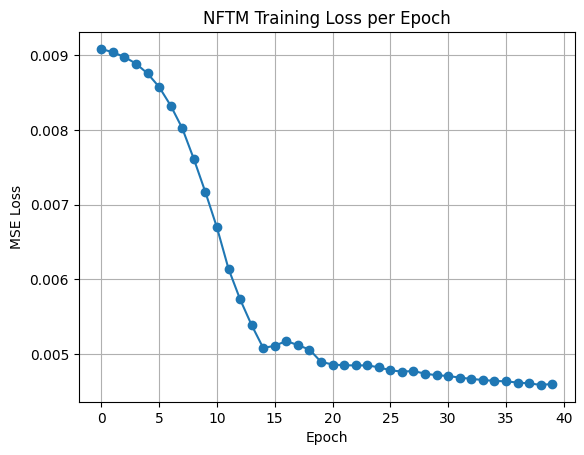

In [198]:
# Loss Evolution Plot
plt.figure()
plt.plot(epoch_losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('NFTM Training Loss per Epoch')
plt.grid(True)
plt.show()